# Variables globales

In [1]:
test_mode = True
verbose = True
import networkx as nx

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.cluster.hierarchy import DisjointSet

In [3]:
m_e = 9.10938356e-31 #en kg
hbar = 1.0545718e-34 #en J.s
e = 1.602176634e-19 #en C
phi = 2*e #en eV

In [97]:
N = 30 # Taille de la grille
a = 1e-9 # Taille de chaque maille élémentaire
sigma = 0.3 #Ecart-type du bruit gaussien
n_el_initial = 100
# Précision de la tension : environ 34 décimales
N_iterations = 500 # Nombre d'itérations par étape
prob_deb = 0.2 # Probabilité de rester dans le début de la grille à chaque initialisation
dropout = 0.3 # Probabilité de disparition des sites
coupe = 0.5 #Permet de cadrer la possibilité pour un électron de sortir de sa case, 0.5 pour rester dans sa case

# Initialisation

In [102]:
z = np.zeros((N,N,2)) # Deux grilles : l'une suit les abscisses, l'autre les ordonnées
x = np.random.normal(0,sigma/2,size = (N,N))
y = np.random.normal(0,sigma/2,size = (N,N))
x = np.clip(x,-coupe,coupe) #On empêche les points de sortir de leur case
y = np.clip(y,-coupe,coupe) #Idem
bruit = np.stack((x,y),axis=-1) 
z += bruit #Génère le bruit gaussien

electrons = np.full((N,N),fill_value=0) #Trace de la position des électrons à tout instant sur la grille
traces = {i : [] for i in range(n_el_initial)} #Dictionnaire des chemins des électrons à une phase donnée
sites = np.random.choice([0, 1], size=(N, N), p=[dropout, 1 - dropout])
if test_mode:
    sites = np.ones((N, N), dtype = float) #Pas de dropout pour les tests

proj  = np.zeros(N,dtype = float)
for i in range(N):
    if sites[i,0]==1:
        proj[i] = abs(y[i,0])
s = np.sum(proj)
if s > 0:
    proj /= s

In [6]:
def reinitialise():
    """Permet de réinitialiser les paramètres entre deux modélisations"""
    global x,y,z,electrons,bruit,traces, sites, proj
    z = np.zeros((N,N,2)) # Deux grilles : l'une suit les abscisses, l'autre les ordonnées
    x = np.random.normal(0,sigma/2,size = (N,N))
    y = np.random.normal(0,sigma/2,size = (N,N))
    x = np.clip(x,-coupe,coupe) #On empêche les points de sortir de leur case
    y = np.clip(y,-coupe,coupe) #Idem
    bruit = np.stack((x,y),axis=-1) 
    z += bruit #Génère le bruit gaussien

    electrons = np.full((N,N),fill_value=0) #Trace de la position des électrons à tout instant sur la grille
    traces = {i : [] for i in range(n_el_initial)} #Dictionnaire des chemins des électrons à une phase donnée
    sites = np.random.choice([0, 1], size=(N, N), p=[dropout, 1 - dropout])
    if test_mode:
        sites = np.ones((N, N), dtype = float) #Pas de dropout pour les tests
    
    proj  = np.zeros(N,dtype = float)
    for i in range(N):
        if sites[i,0]==1:
            proj[i] = abs(y[i,0])
    s = np.sum(proj)
    if s > 0:
        proj /= s

# Affichage

## Représentation en grille

In [55]:
def affiche_grille(z):
    N,_,_ = z.shape
    plt.xticks(np.arange(0,N,1), labels = [])
    plt.yticks(np.arange(0,N,1), labels = [])
    for i in range(N):
        for j in range(N):
            if sites[i,j]==1:
                xc = i+0.5 + z[i,j,0]
                yc = j+0.5 + z[i,j,1]
                plt.scatter(xc,yc, color = "red")
    plt.grid()

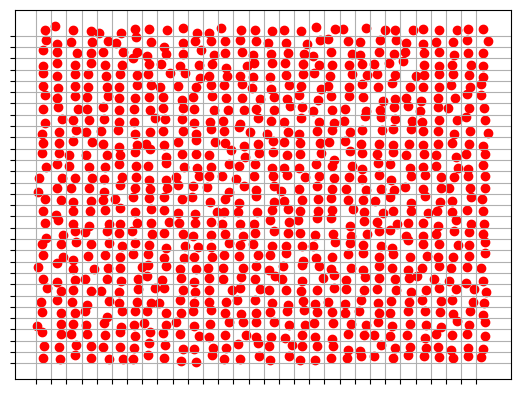

In [8]:
if verbose:
    affiche_grille(z)

In [9]:
def affiche_electrons(electrons):
    fig, ax = plt.subplots()
    N,_ = electrons.shape
    plt.xticks(np.arange(0,N+1,1), labels = [])
    plt.yticks(np.arange(0,N+1,1), labels = [])
    for i in range(N):
        for j in range(N):
            if electrons[i,j]>0:
                rect = patches.Rectangle((i, j), 1, 1, color='black', alpha=0.5) 
                ax.add_patch(rect)           
    plt.grid()

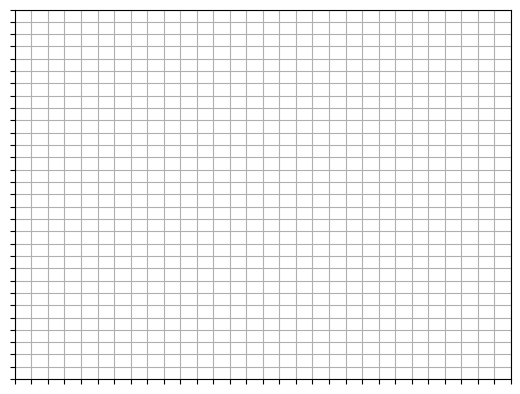

In [10]:
if verbose:
    affiche_electrons(electrons)

In [11]:
def heatmap(electrons):
    """Affiche la carte de chaleur des électrons sur la grille"""
    plt.figure(figsize=(10, 10))
    plt.xticks(ticks=np.arange(electrons.shape[1]), labels=np.arange(electrons.shape[1]))
    plt.yticks(ticks=np.arange(electrons.shape[0]), labels=np.arange(electrons.shape[0]))

    # Tracer la heatmap
    plt.imshow(electrons, cmap=plt.cm.Blues, vmin=1)  # vmin=1 pour que les valeurs 0 soient blanches
    plt.colorbar()  # Ajouter une barre de couleur
    plt.title('Carte des électrons')
    plt.show()

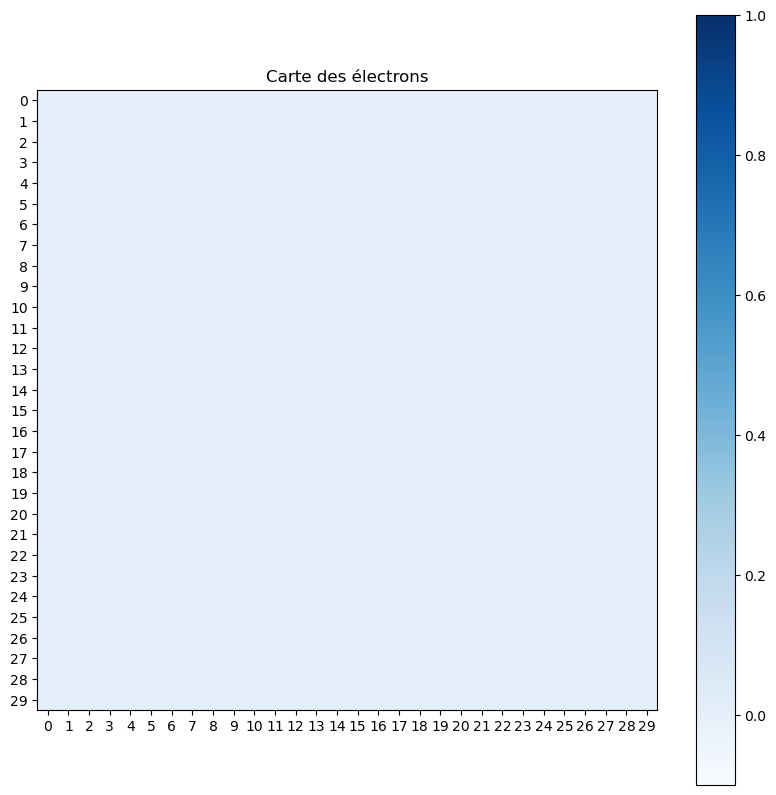

In [12]:
if verbose:
    heatmap(electrons)

## Représentation en graphe

In [122]:
def affiche_graphes_colormap(probabilites):
    global electrons, sites
    G = nx.DiGraph()

    for case, voisines in probabilites.items():
        for voisine, prob in voisines.items():
            G.add_edge(case, voisine, weight=prob)

    # Positionner les nœuds dans une grille
    pos = {(i, j): (j + x[j, i], N - i - y[j, i]) for i in range(N) for j in range(N)}

    fig, ax = plt.subplots(figsize=(30, 30))  # Ajustez la taille de la figure ici

    cmap_nodes = plt.get_cmap('coolwarm')


    # Dessiner les nœuds avec une taille réduite et une colormap basée sur electrons
    node_values = [electrons[i, j] for i in range(N) for j in range(N)]
    nx.draw(
        G, pos, with_labels=False, node_size=100, node_color=node_values, 
        cmap=cmap_nodes, ax=ax, arrows=False, edgelist=[]
    )

    # Dessiner les arêtes avec des couleurs basées sur les poids
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    max_weight = max(weights) if weights else 1
    #colors = [weight / max_weight for weight in weights]  # Normalisation entre 0 et 1
    cmap_edges = plt.get_cmap('coolwarm')

    # Dessiner les arêtes avec des flèches
    nx.draw_networkx_edges(
        G, pos, edge_color=weights, edge_cmap=cmap_edges, edge_vmin=0, edge_vmax=max_weight,
        connectionstyle="arc3,rad=0.3", arrows=True, ax=ax
    )

    # Ajouter une barre de couleur pour les nœuds
    sm_nodes = plt.cm.ScalarMappable(cmap=cmap_nodes, norm=plt.Normalize(0, max(node_values)))
    sm_nodes.set_array([])
    cbar_nodes = plt.colorbar(sm_nodes, ax=ax, label='Valeur des électrons')

    # Ajouter une barre de couleur pour les arêtes
    sm_edges = plt.cm.ScalarMappable(cmap=cmap_edges, norm=plt.Normalize(0, max_weight))
    sm_edges.set_array([])
    cbar_edges = plt.colorbar(sm_edges, ax=ax, label='Probabilité')

    # Afficher le graphe
    plt.title("Graphe des probabilités de transition avec colormap des électrons")
    plt.show()


In [ ]:
probas = dico_probas(4)
affiche_graphes_colormap(probas)

In [13]:
def affichage_graphes(probabilites):
    G = nx.DiGraph()

    # Ajouter des arêtes avec des poids
    for case, voisines in probabilites.items():
        for voisine, prob in voisines.items():
            G.add_edge(case, voisine, weight=prob)

    # Positionner les nœuds dans une grille
    pos = {case: (case[0], case[1]) for case in G.nodes()}

    fig, ax = plt.subplots(figsize=(15, 15))  # Ajustez la taille de la figure ici

    # Dessiner les nœuds avec une taille réduite
    nx.draw(G, pos, with_labels=False, node_size=300, node_color='lightblue', arrows=True, ax=ax)  # Réduisez node_size

    # Dessiner les arêtes avec des couleurs basées sur les poids
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    max_weight = max(weights) if weights else 1
    colors = [weight / max_weight for weight in weights]  # Normalisation entre 0 et 1
    cmap = plt.get_cmap('viridis')

    # Dessiner les arêtes
    nx.draw_networkx_edges(G, pos, edge_color=colors, edge_cmap=cmap, width=2, alpha=0.7, ax=ax)

    # Ajouter une barre de couleur
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, max_weight))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label='Probabilité')

    # Afficher le graphe
    plt.title("Graphe des probabilités de transition")
    plt.show()

# Initialisation

In [56]:
def first_initialisation():
    global y, n_el_initial, sites, traces, electrons, proj
    """Initialise la position des électrons lors de la première passe"""
    pos = np.random.choice(np.arange(N), size = n_el_initial, p = proj)
    for electron in range(n_el_initial):
        position = pos[electron]
        electrons[position,0] += 1
        traces[electron] = [(position,0)]

Probabilités utilisées: [0.00025357 0.03044232 0.0583973  0.00253737 0.01895797 0.03025225
 0.02826152 0.05632817 0.00216697 0.07593162 0.10836384 0.05330954
 0.0345839  0.03209919 0.02956612 0.04252839 0.03440471 0.05400035
 0.04721745 0.01276786 0.00076127 0.04517036 0.0371348  0.01123696
 0.06452159 0.0305021  0.00668665 0.00105004 0.04461524 0.00595059]
Position des électrons : {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: [], 12: [], 13: [], 14: [], 15: [], 16: [], 17: [], 18: [], 19: [], 20: [], 21: [], 22: [], 23: [], 24: [], 25: [], 26: [], 27: [], 28: [], 29: [], 30: [], 31: [], 32: [], 33: [], 34: [], 35: [], 36: [], 37: [], 38: [], 39: [], 40: [], 41: [], 42: [], 43: [], 44: [], 45: [], 46: [], 47: [], 48: [], 49: [], 50: [], 51: [], 52: [], 53: [], 54: [], 55: [], 56: [], 57: [], 58: [], 59: [], 60: [], 61: [], 62: [], 63: [], 64: [], 65: [], 66: [], 67: [], 68: [], 69: [], 70: [], 71: [], 72: [], 73: [], 74: [], 75: [], 76: [], 77: [], 

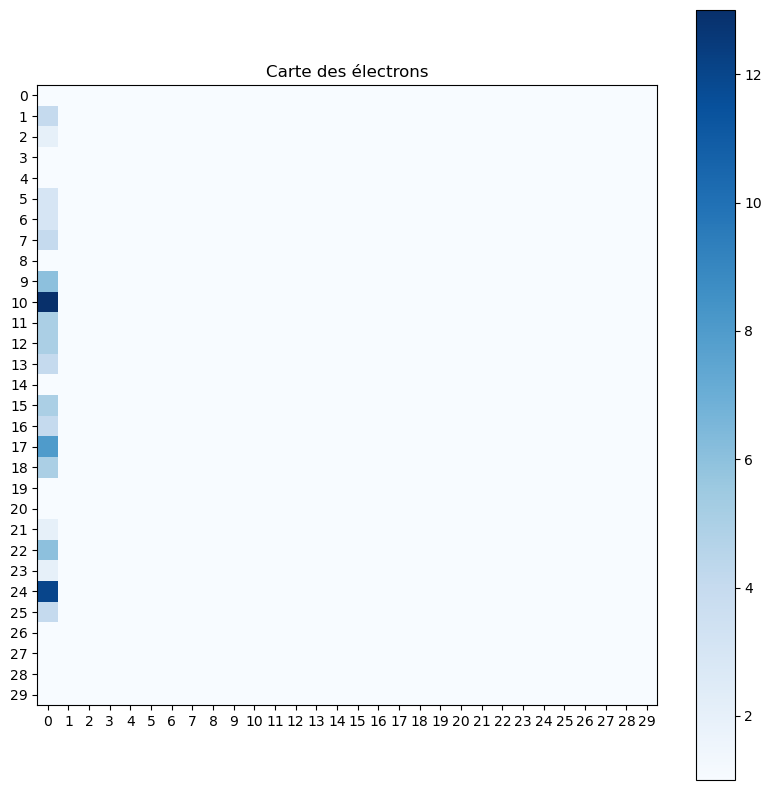

In [15]:
if verbose:
    print(f"Probabilités utilisées: {proj}")
    print(f"Position des électrons : {traces}")
    first_initialisation()
    heatmap(electrons)

In [57]:
def initialise(chemins):
    global y, n_el_initial, sites, traces, electrons, proj
    """Initialise la position des électrons lors des passes suivantes. 
    Utilise la liste des chemins existants."""
    for elec in range(n_el_initial):
        t = np.random.choice(["Début", "Fin"], p = [prob_deb, 1 - prob_deb])
        if t=="Début":
            position = np.random.choice(np.arange(N), p = proj)
            electrons[position,0] += 1
            traces[elec] = [(position,0)]
        else:
            chem = np.random.choice(np.arange(len(chemins)))
            pos_chem = np.random.choice(np.arange(len(chemins[chem])))
            position = chemins[chem][pos_chem]
            electrons[position] += 1
            traces[elec] = [position]

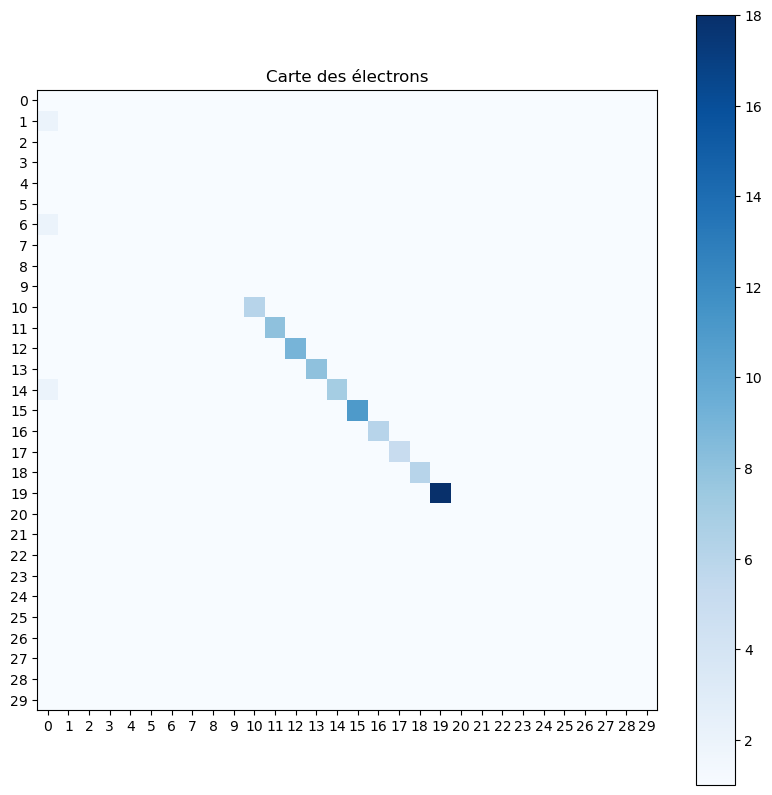

In [17]:
if verbose:
    reinitialise()
    initialise([[(10,10)],[(11,11)],[(12,12)],[(13,13)],[(14,14)],[(15,15)],[(16,16)],[(17,17)],[(18,18)],[(19,19)]])
    heatmap(electrons)

# Probabilités de déplacement

In [18]:
def position_into_reality(i,j):
    return a*(i+z[i,j,0]),a*(j+z[i,j,1])

In [19]:
def distance(i,j,k,l):
    xi,yi = position_into_reality(i,j)
    xj,yj = position_into_reality(k,l)
    return np.sqrt((xi-xj)**2 + (yi-yj)**2)

In [20]:
def tension(V,i,j):
    """Calcule le potentiel en un point de la grille"""
    return (1-(j/N))*V*e

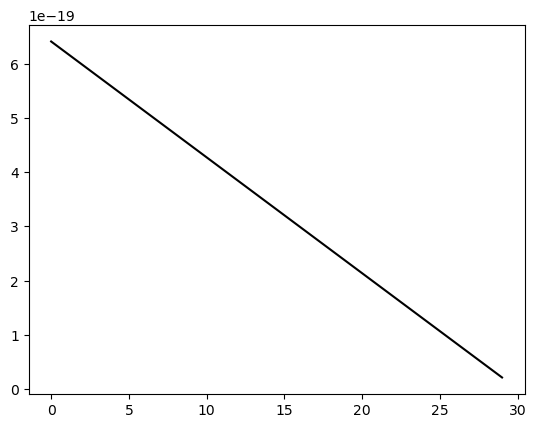

In [ ]:
#plt.plot(np.arange(0,N), [tension(4.,0,j) for j in range(N)], color = "black", label = "V=0")

In [22]:
def prob(V,i,j,k,l):
    """Renvoie la probabilité de passer d'une case à une autre"""
    Delta = distance(i,j,k,l)
    V_i = tension(V,i,j)
    V_f = tension(V,k,l)
    V = max(V_i,V_f) + phi
    E = np.random.random()*(V-V_i)+V_i
    if E<V_f:
        return 0.
    else:
        k = np.sqrt(2*m_e*(E-V_i))/hbar
        K = np.sqrt(2*m_e*(V-E))/hbar
        kappa = np.sqrt(2*m_e*(E-V_f))/hbar
        #print(V_i,V_f,E)
        #print(k,K,kappa)
        #print(Delta)
        t = 4*np.exp(-kappa*Delta*1j) * (2*(1+kappa/k)*np.cosh(K*Delta) -2*(1j*kappa/K + K/(1j*k))*np.sinh(K*Delta))**(-1)
        return abs(t)

In [23]:
prob(4.,15,15,15,16)

np.float64(0.1432666366174053)

In [103]:
def calcul_probas(V,i,j):
    droite,gauche,haut,bas = 0.,0.,0.,0.
    phi = 2*1.60217662e-19
    if j<N-1:
        if j+1<N and sites[i,j+1] == 1:
            haut = prob(V,i,j,i,j+1)
        if j>0 and sites[i,j-1] == 1:
            bas = prob(V,i,j,i,j-1)
        if i+1<N and sites[i+1,j] == 1:
            droite = prob(V,i,j,i+1,j)
        if i>0 and sites[i-1,j] == 1:
            gauche = prob(V,i,j,i-1,j)
        sum = droite + gauche + haut + bas
        if sum==0:
            return 0.,0.,0.,0.
        else:
            return droite/sum,gauche/sum,haut/sum,bas/sum
    else:
        return 0.,0.,0.,0.

In [104]:
def calcul_probas_old(V,i,j):
    droite,gauche,haut,bas = 0.,0.,0.,0.
    phi = 2*1.60217662e-19
    if j<N-1:
        if j+1<N and sites[i,j+1] == 1:
            haut = 3
        if j>0 and sites[i,j-1] == 1:
            bas = 1
        if i+1<N and sites[i+1,j] == 1:
            droite = 1.5
        if i>0 and sites[i-1,j] == 1:
            gauche = 1.5
        sum = droite + gauche + haut + bas
        if sum==0:
            return 0.,0.,0.,0.
        else:
            return droite/sum,gauche/sum,haut/sum,bas/sum
    else:
        return 0.,0.,0.,0.

In [105]:
def pp_probas(V,case):
    droite,gauche,haut,bas = calcul_probas(V,case[0],case[1])
    print(f"Case ({case[0]}, {case[1]}):")
    print(f"\t Probabilité d'aller à droite : {droite}")
    print(f"\t Probabilité d'aller à gauche : {gauche}")
    print(f"\t Probabilité d'aller en haut : {haut}")
    print(f"\t Probabilité d'aller en bas : {bas}")

In [27]:
if verbose:
    pp_probas(30,(8,8))

Case (8, 8):
	 Probabilité d'aller à droite : 0.07423115830505117
	 Probabilité d'aller à gauche : 0.29370358966928706
	 Probabilité d'aller en haut : 0.006844827262457374
	 Probabilité d'aller en bas : 0.6252204247632044


In [106]:
def dico_probas(V,seuil=1e-10):
    """Renvoie un dictionnaire contenant les probabilités de chaque case"""
    dico = {}
    for i in range(N):
        for j in range(N):
            dico[(i,j)] = {}
            if sites[i,j]==1:
                droite,gauche,haut,bas = calcul_probas_old(V,i,j)
                if droite>seuil:
                    dico[(i,j)][(i+1,j)] = droite
                if gauche>seuil:
                    dico[(i,j)][(i-1,j)] = gauche
                if haut>seuil:
                    dico[(i,j)][(i,j+1)] = haut
                if bas>seuil:
                    dico[(i,j)][(i,j-1)] = bas
    return dico

In [29]:
if verbose:
    print(dico_probas(30))

{(0, 0): {(1, 0): 0.3333333333333333, (0, 1): 0.6666666666666666}, (0, 1): {(1, 1): 0.2727272727272727, (0, 2): 0.5454545454545454, (0, 0): 0.18181818181818182}, (0, 2): {(1, 2): 0.2727272727272727, (0, 3): 0.5454545454545454, (0, 1): 0.18181818181818182}, (0, 3): {(1, 3): 0.2727272727272727, (0, 4): 0.5454545454545454, (0, 2): 0.18181818181818182}, (0, 4): {(1, 4): 0.2727272727272727, (0, 5): 0.5454545454545454, (0, 3): 0.18181818181818182}, (0, 5): {(1, 5): 0.2727272727272727, (0, 6): 0.5454545454545454, (0, 4): 0.18181818181818182}, (0, 6): {(1, 6): 0.2727272727272727, (0, 7): 0.5454545454545454, (0, 5): 0.18181818181818182}, (0, 7): {(1, 7): 0.2727272727272727, (0, 8): 0.5454545454545454, (0, 6): 0.18181818181818182}, (0, 8): {(1, 8): 0.2727272727272727, (0, 9): 0.5454545454545454, (0, 7): 0.18181818181818182}, (0, 9): {(1, 9): 0.2727272727272727, (0, 10): 0.5454545454545454, (0, 8): 0.18181818181818182}, (0, 10): {(1, 10): 0.2727272727272727, (0, 11): 0.5454545454545454, (0, 9): 0

In [35]:
probas = dico_probas(4)
affiche_graphes(probas)

TypeError: unhashable type: 'dict'

# Réalisation d'une transition

In [ ]:
def deplacement(V,elec,probs):
    global electrons,traces
    i,j = traces[elec][-1]
    clefs = list(probs[(i,j)].keys())
    if len(clefs) != 0:
        valeurs = list(probs[(i,j)].values())
        indice = np.random.choice(np.arange(len(clefs)), p = valeurs)
        new = clefs[indice]
        traces[elec].append(new)
        electrons[i,j] -= 1
        electrons[new[0],new[1]] += 1

In [ ]:
def transition(V):
    probas = dico_probas(V)
    for k in range(n_el_initial):
        deplacement(V,k,probas)

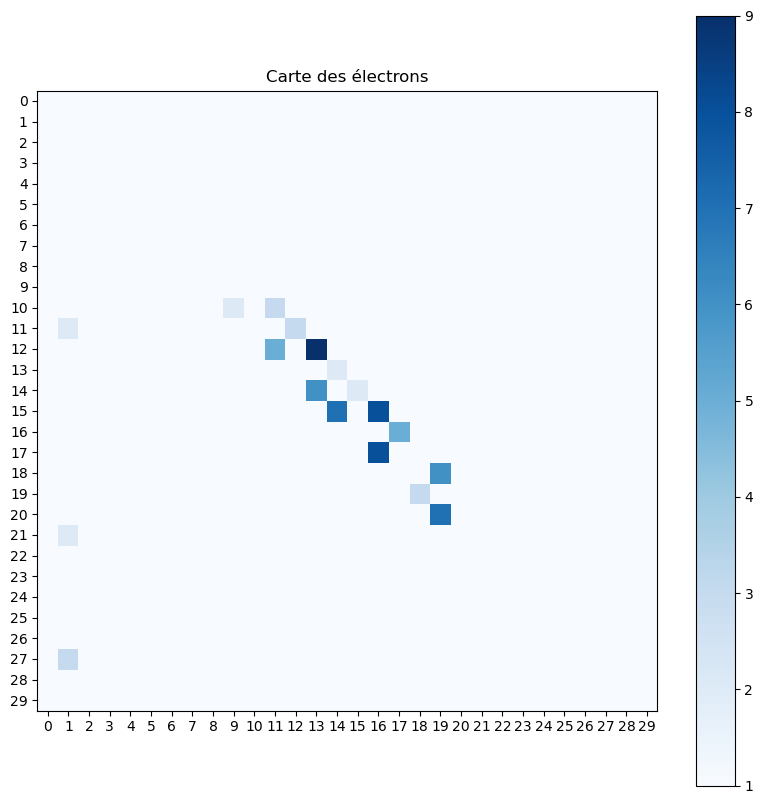

In [ ]:
if verbose:
    #reinitialise()
    #first_initialisation()
    transition(4.)
    heatmap(electrons)

# Réalisation de l'étape

In [ ]:
def calcule_intensite(V,chem):
    li = np.array([len(chemin) for chemin in chem])
    res = 1/(np.sum(1/li))
    return V/res

In [ ]:
def etape(V, chem, first = False):
    global traces, n_el_initial,N_iterations
    if first:
        first_initialisation()
    else:
        initialise(chem)
    for i in range(N_iterations):
        transition(V)
    liste = [chemin for chemin in traces.values() if chemin[-1][1]==N-1]
    return calcule_intensite(V,liste),liste
    

In [ ]:
def simulation(array_V,affiche = True, trace_carac = True):
    reinitialise()
    chem = []
    intense = []
    for (i,V) in enumerate(array_V):
        intensite, chem = etape(V,chem,(i==0))
        intense.append(intensite)
        print(f"Etape {i}, Intensité : {intensite}")
        if affiche:
            heatmap(electrons)
    if trace_carac:
        plt.scatter(array_V,intense)
        plt.xlabel("Tension (V)")
        plt.ylabel("Intensité (A)")
        plt.title("Caractéristique I(V)")
        plt.grid()
        plt.show()
    return intense

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
Etape 0, Intensité : 0.0


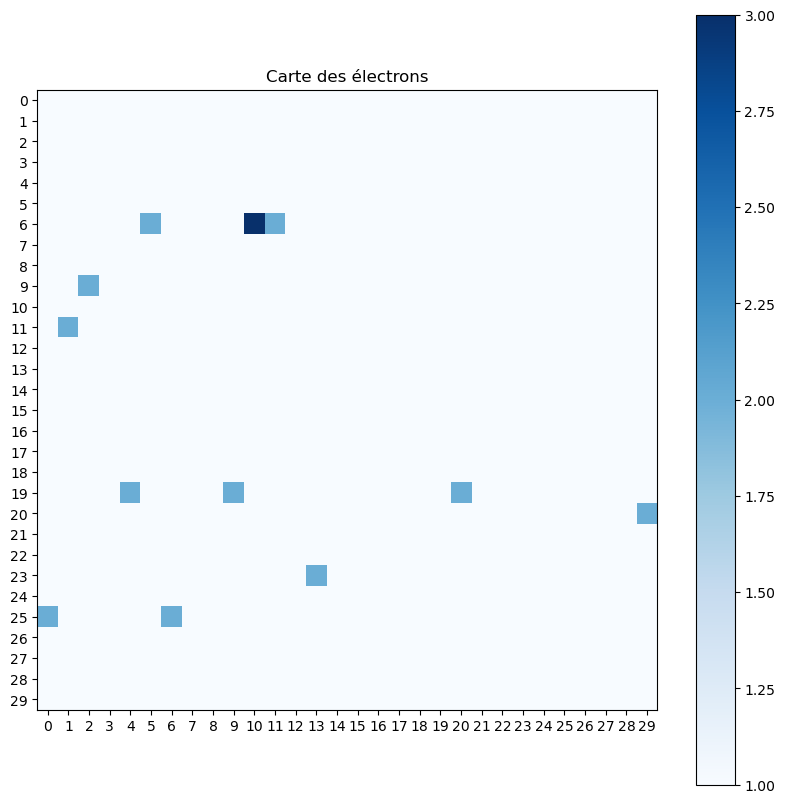

Etape 1, Intensité : 0.5700004835477909


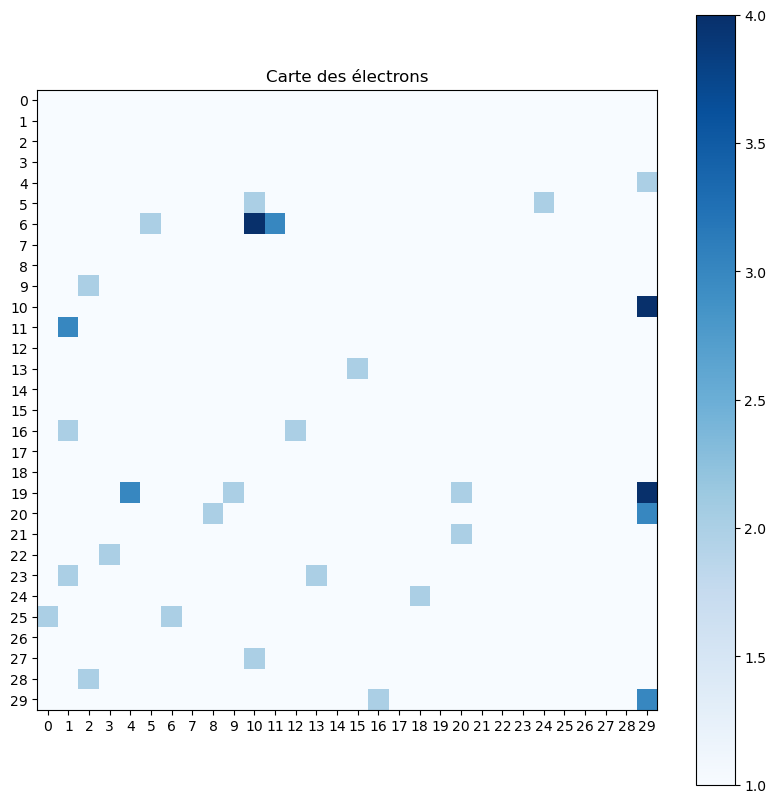

Etape 2, Intensité : 6.154240537519808


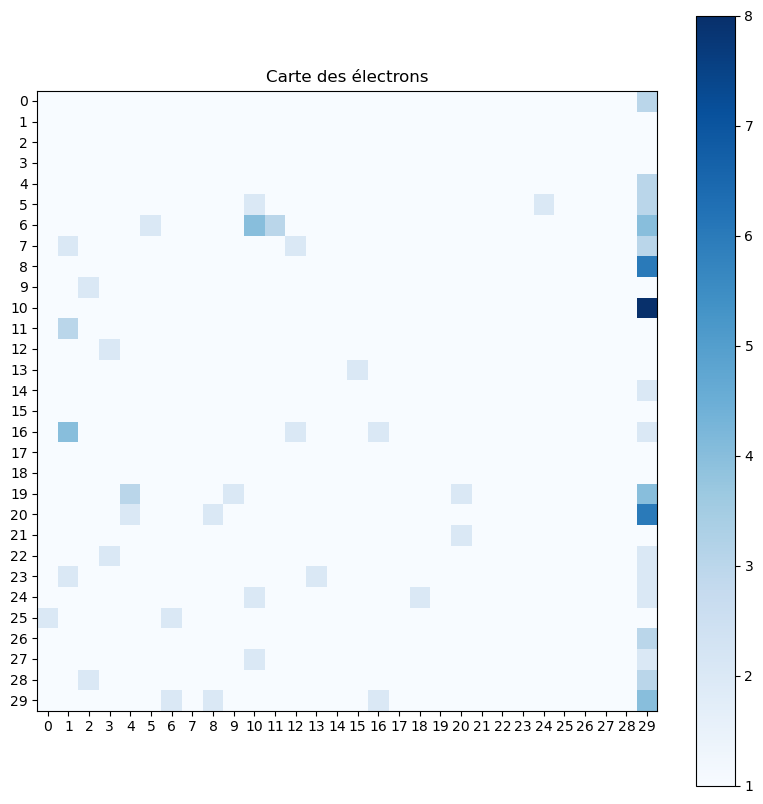

Etape 3, Intensité : 26.70803701245752


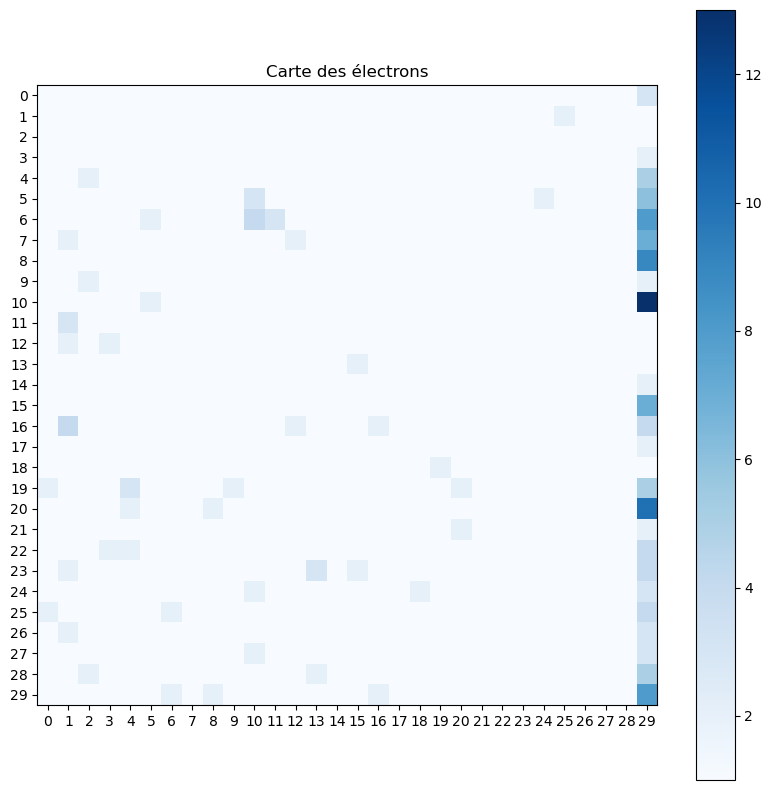

Etape 4, Intensité : 61.57986760072528


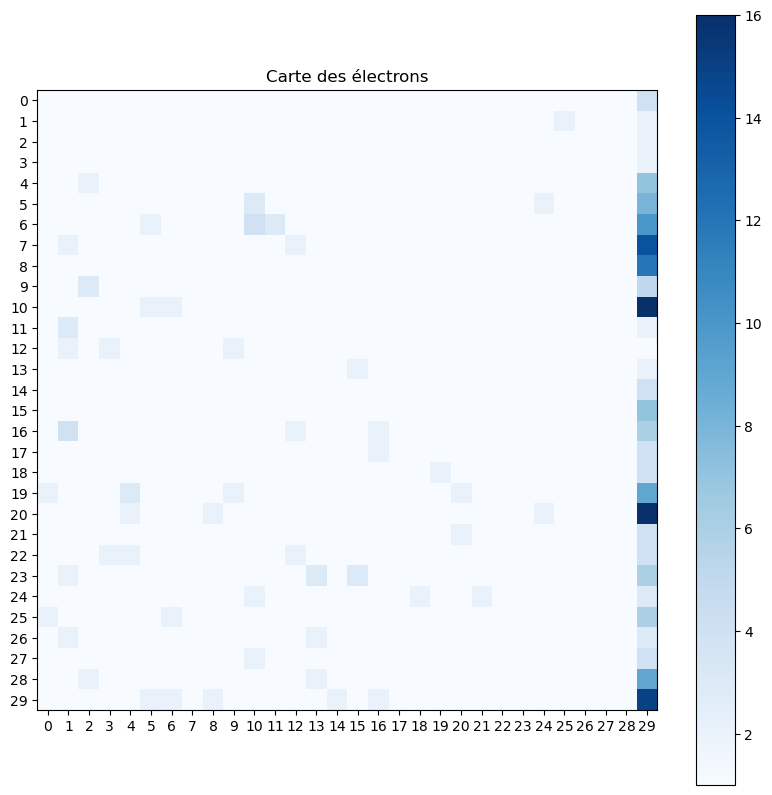

Etape 5, Intensité : 113.09747586415291


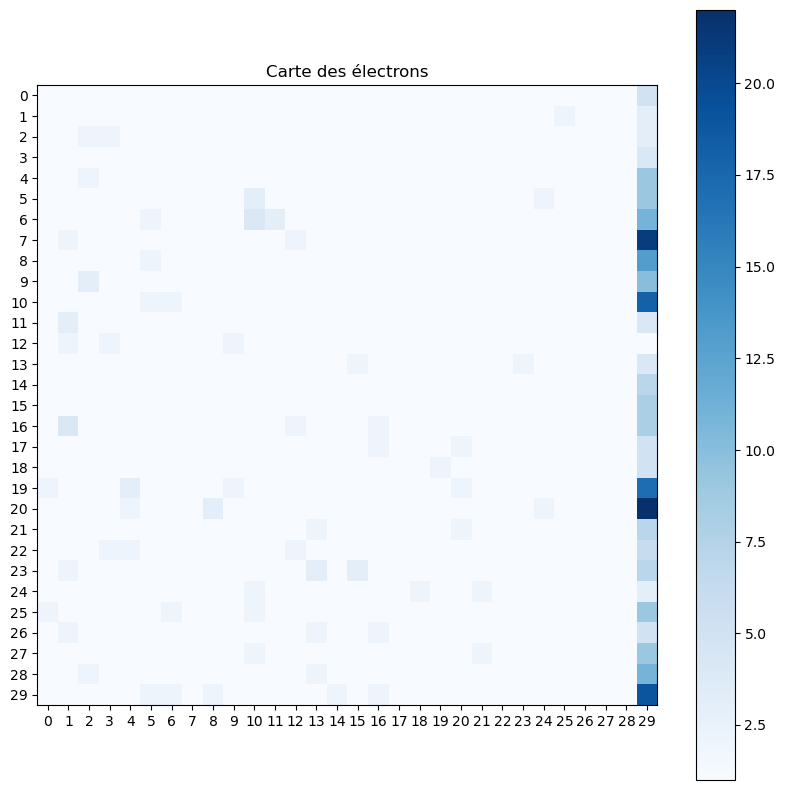

Etape 6, Intensité : 123.16426345374958


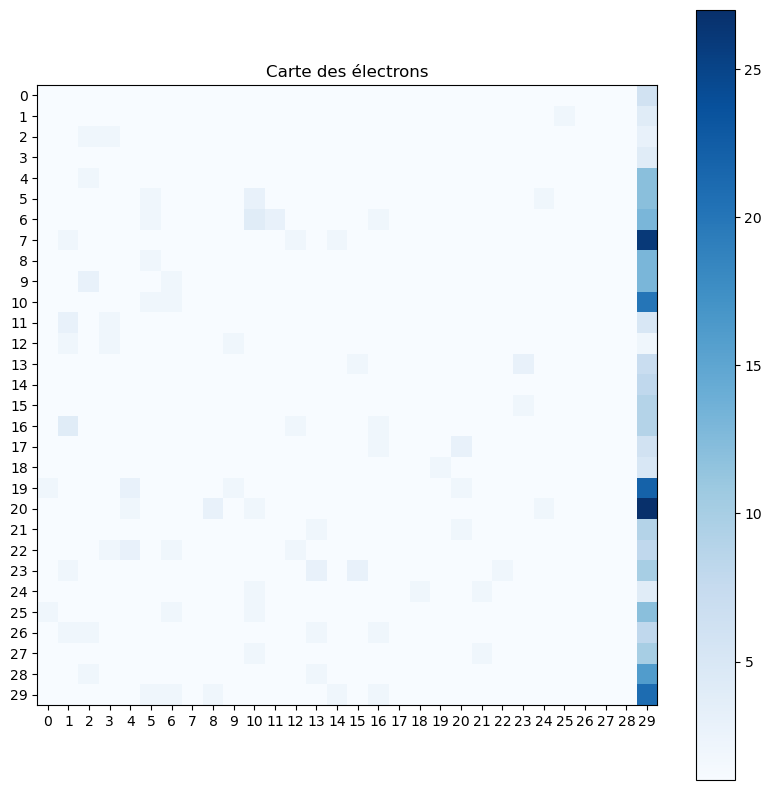

Etape 7, Intensité : 240.71270625709244


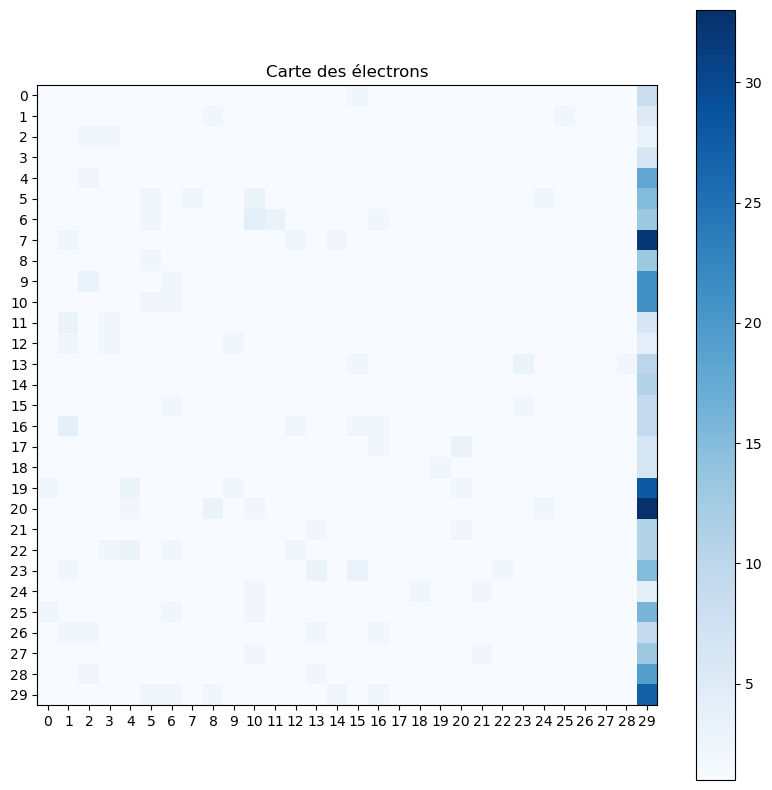

Etape 8, Intensité : 318.6651562913219


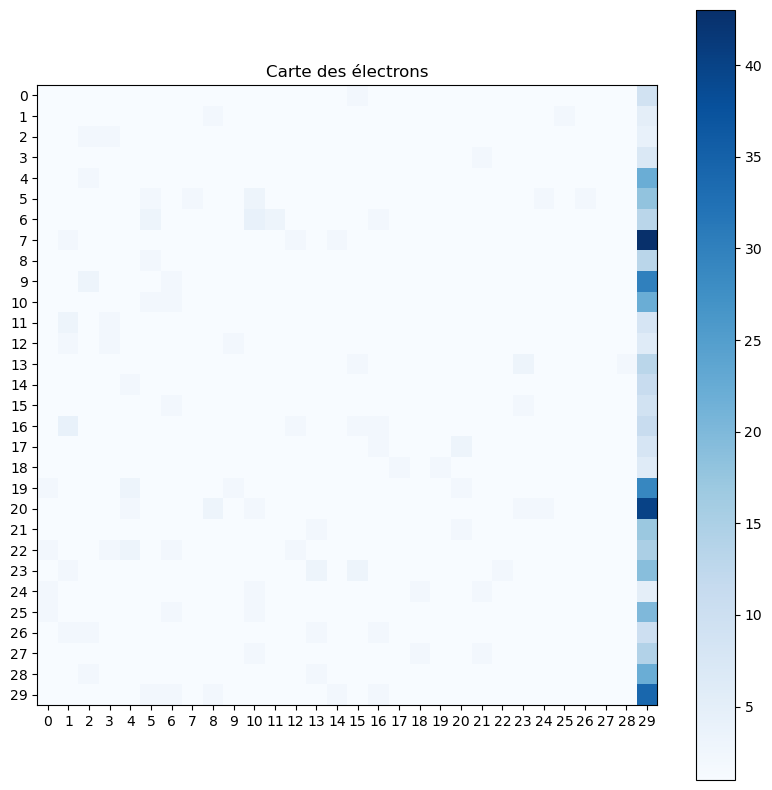

Etape 9, Intensité : 346.0409209988969


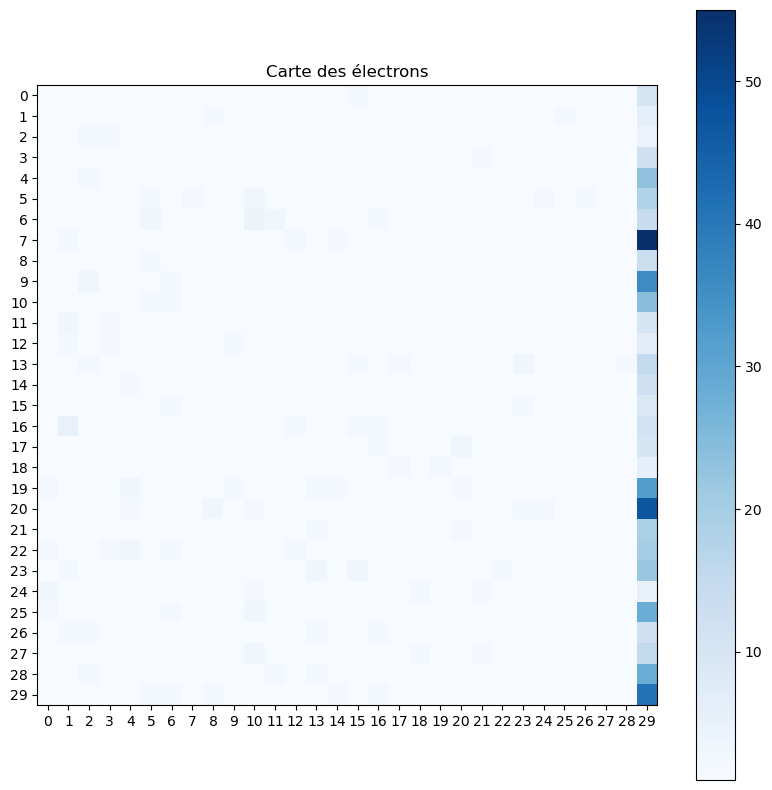

Etape 10, Intensité : 349.53720148334065


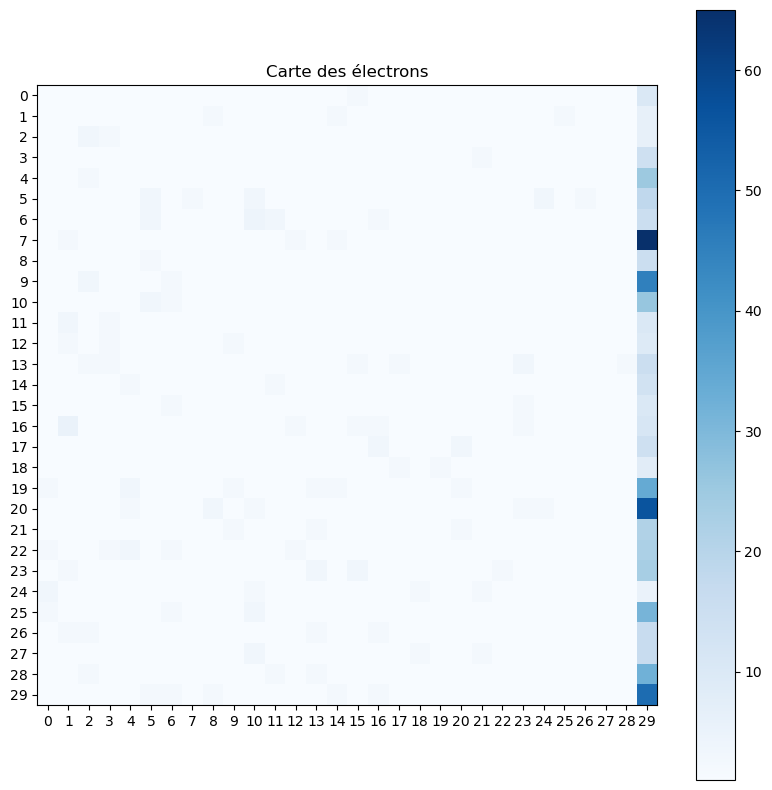

Etape 11, Intensité : 345.3961664784459


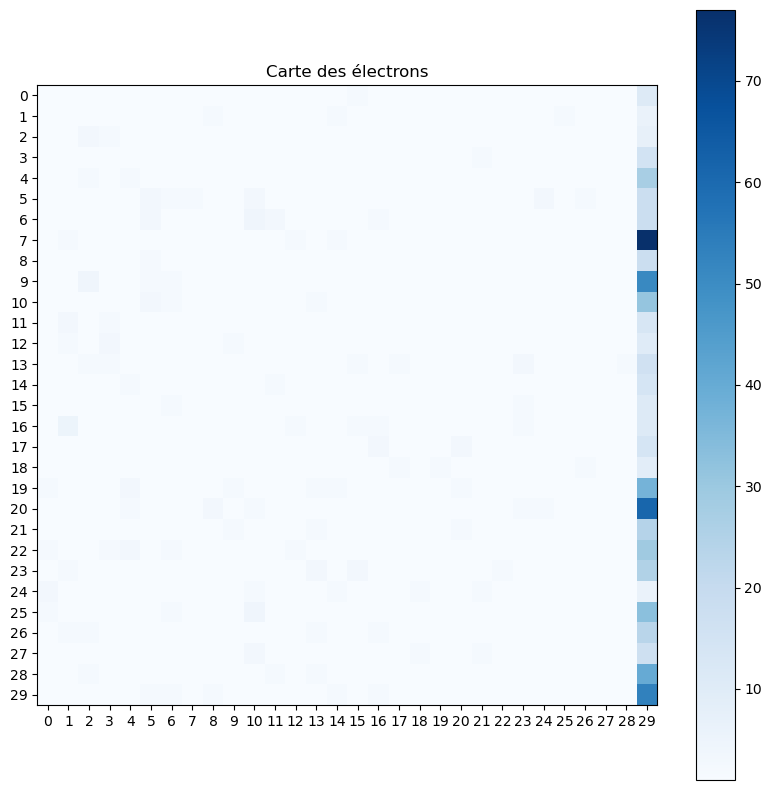

Etape 12, Intensité : 371.54509115015816


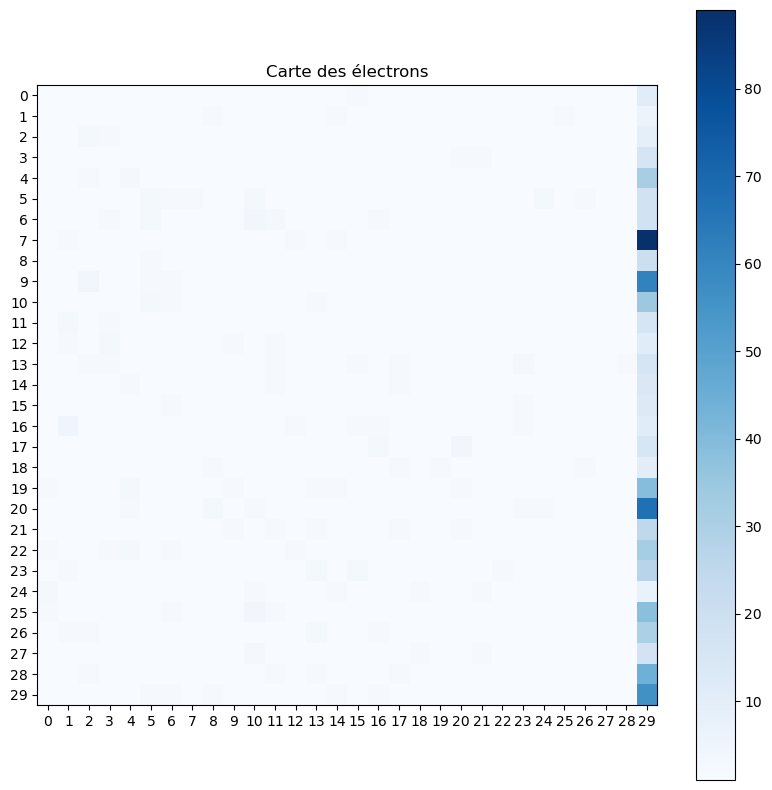

Etape 13, Intensité : 439.6429412045627


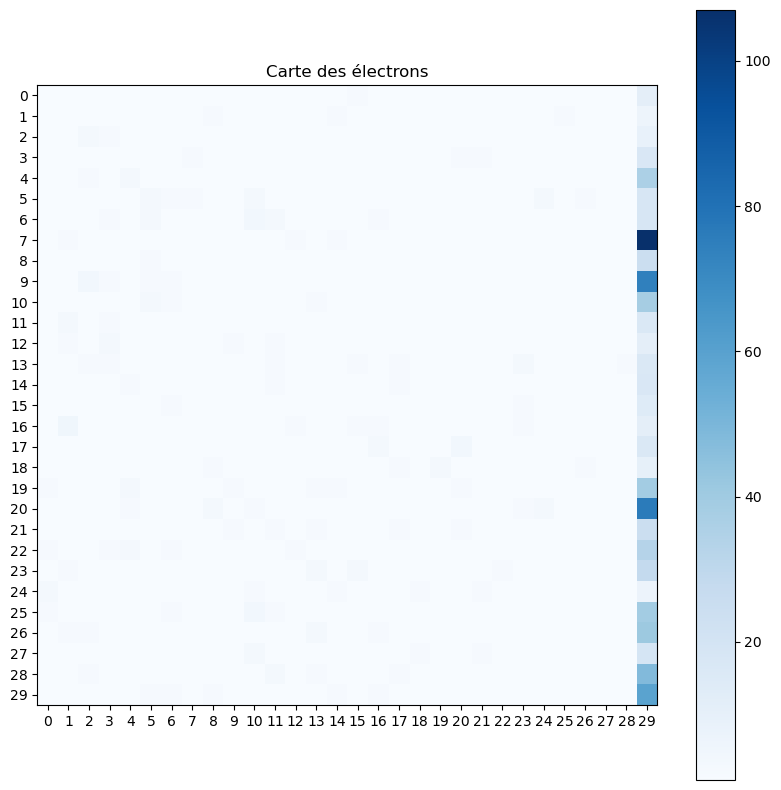

Etape 14, Intensité : 365.64198774337206


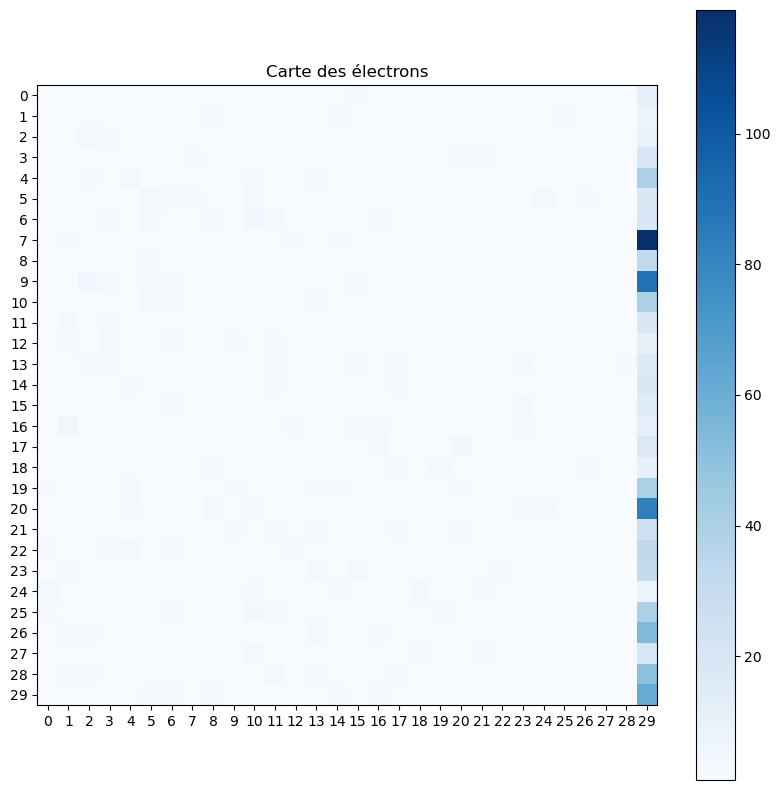

Etape 15, Intensité : 286.5380332033817


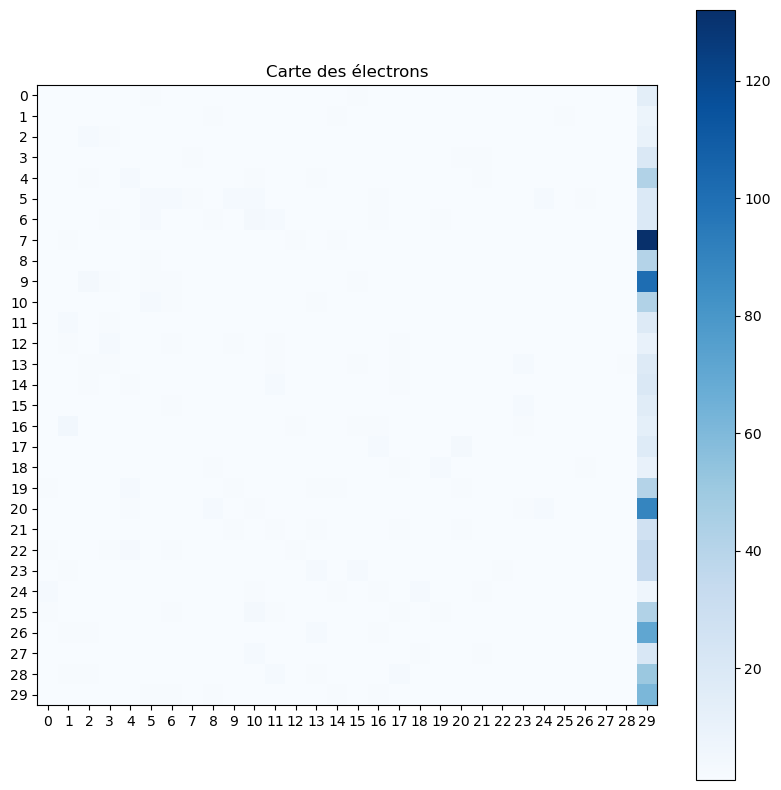

Etape 16, Intensité : 221.13027072156692


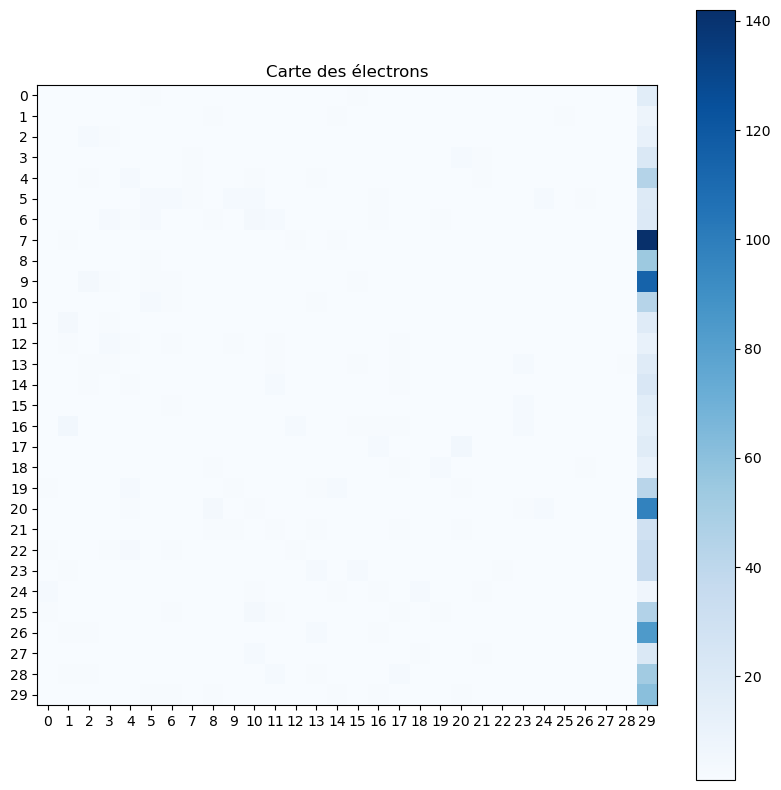

Etape 17, Intensité : 163.54980325985957


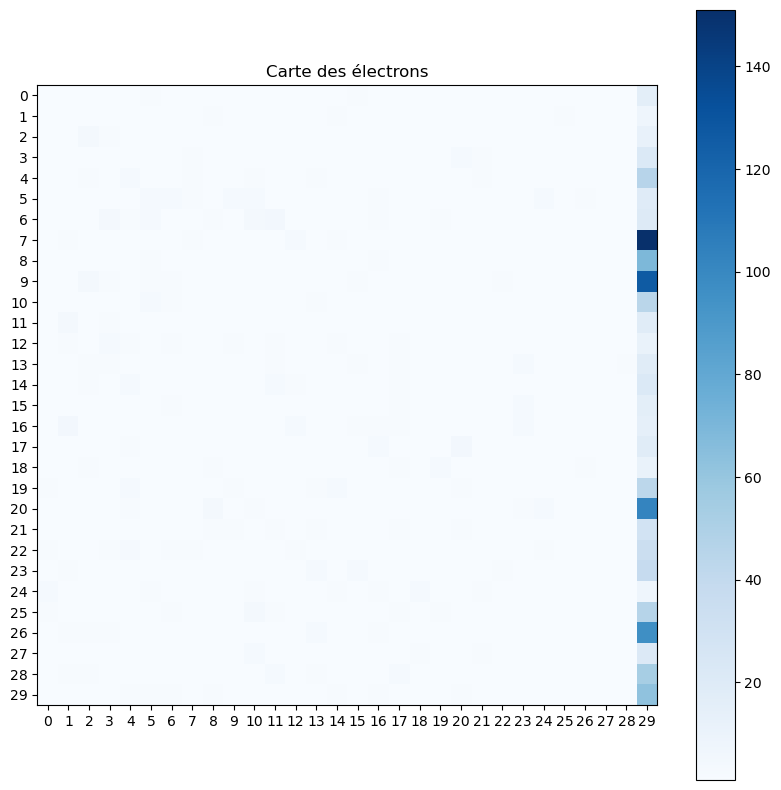

Etape 18, Intensité : 137.55906829743918


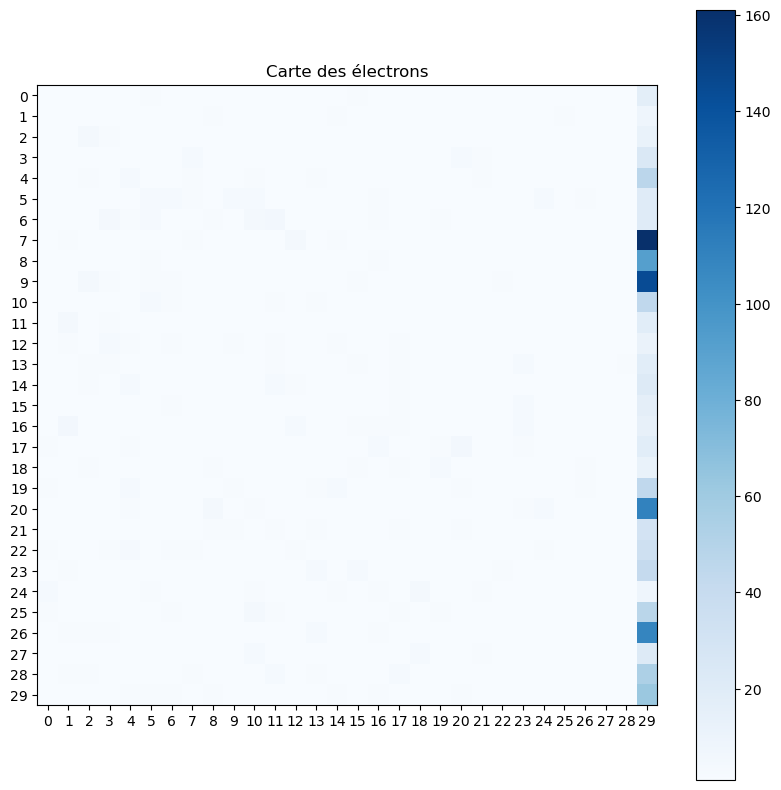

Etape 19, Intensité : 67.283488430756


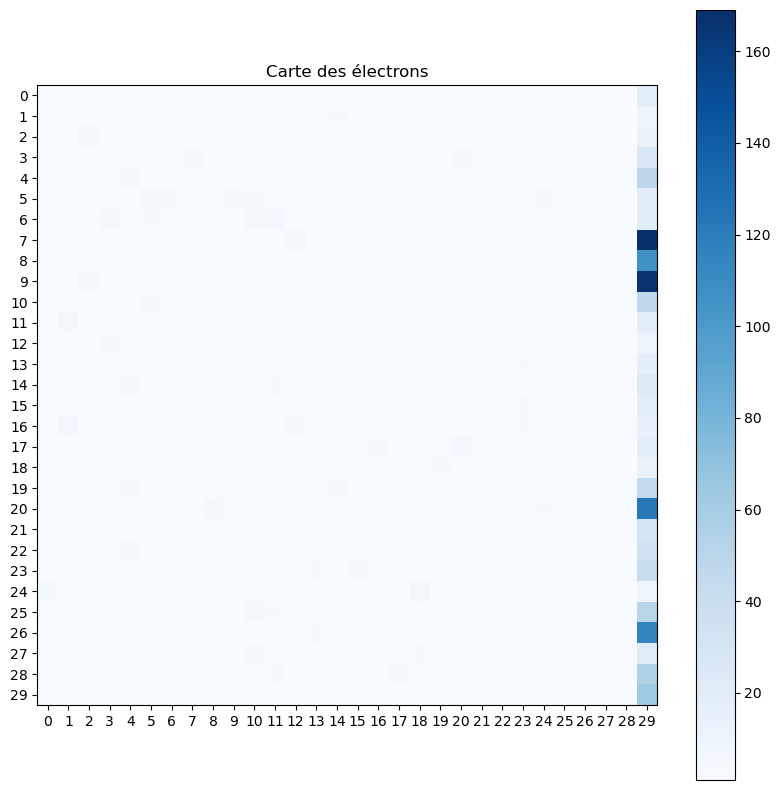

Etape 20, Intensité : 0.0


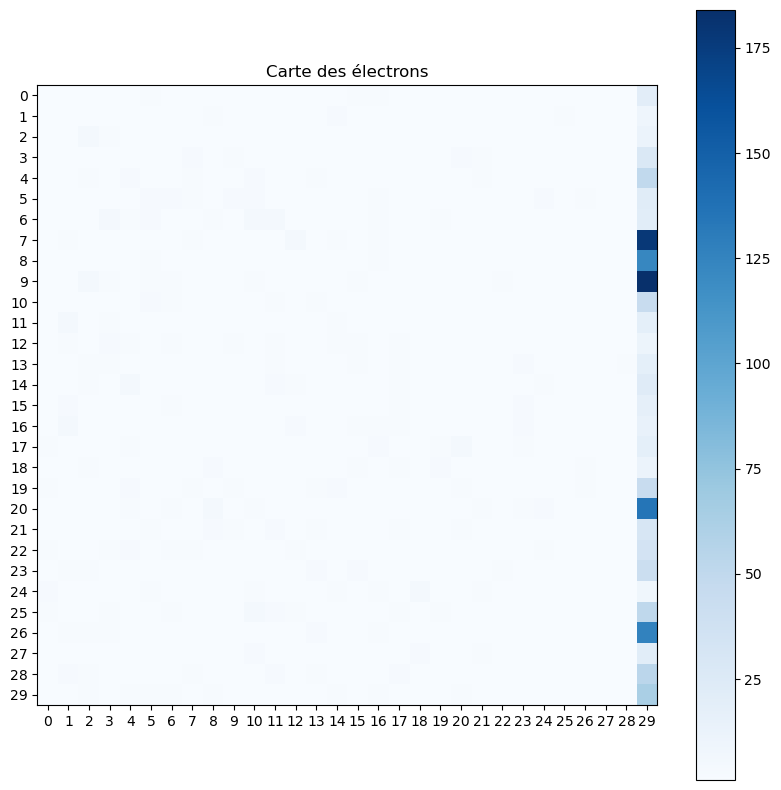

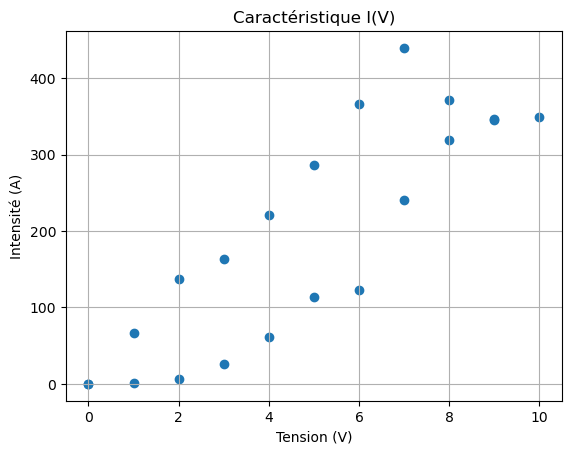

In [ ]:
array_V = list(range(0,10))
array_V += list(range(10,-1,-1))
print(array_V)
simulation(array_V, affiche = True)